## **I. Perkenalan**


**Batch**: CODA-RMT-008

**Judul**: Analisis Penargetan Subsidi Kendaraan Listrik (EV) untuk Mendorong Adopsi yang Merata di Seluruh County Berdasarkan Faktor Sosio-Ekonomi

## **II. Identifikasi Masalah**


#### **Latar Belakang**
Pemerintah memiliki tujuan untuk mempercepat adopsi kendaraan listrik (EV) sebagai bagian dari komitmen terhadap Tujuan Pembangunan Berkelanjutan (SDGs) PBB, khususnya Goal 7 (Energi Bersih), Goal 11 (Kota Berkelanjutan), dan Goal 13 (Aksi Iklim). Namun, data saat ini menunjukkan bahwa penyebaran EV tidak merata, dengan beberapa wilayah (county) yang tertinggal jauh. Diduga, faktor sosio-ekonomi seperti Upah Minimum Regional (Gaji rata-rata) dan karakteristik wilayah seperti kepadatan penduduk menjadi penghalang utama.

Analisis ini bertujuan untuk mengidentifikasi wilayah-wilayah dengan tingkat penetrasi EV yang rendah, memahami hubungannya dengan faktor ekonomi, dan merekomendasikan model-model EV yang paling cocok untuk disubsidi di wilayah tersebut. Dengan demikian, program subsidi pemerintah dapat menjadi lebih tepat sasaran, efektif, dan mendorong adopsi yang lebih merata.

### **Problem Statements**
Penyebaran kendaraan listrik (EV) di Washington masih belum merata, dengan beberapa county menunjukkan tingkat penetrasi EV yang rendah. Kondisi ini diduga dipengaruhi oleh faktor sosio-ekonomi seperti rendahnya Upah Minimum Regional (Gaji rata-rata) serta karakteristik wilayah seperti kepadatan penduduk. Tanpa analisis yang tepat, kebijakan subsidi pemerintah berisiko tidak efektif dan tidak tepat sasaran. Oleh karena itu, perlu dilakukan identifikasi wilayah dengan penetrasi EV rendah, analisis hubungan dengan faktor ekonomi, serta rekomendasi model EV yang paling sesuai untuk disubsidi agar program pemerintah dapat lebih adil, efisien, dan mendorong adopsi EV secara merata.

#### **Defining the Problem Statement (Kerangka SMART)**
* **Specific**: Mengidentifikasi county, lalu menganalisis karakteristik UMR dan kepadatan penduduk untuk menetapkan strategi subsidi berbasis diferensiasi wilayah.

* **Measurable**: Mengukur tingkat penetrasi EV, rata-rata Gaji rata-rata, kepadatan penduduk, serta pangsa pasar dan harga dari model-model EV yang relevan.

* **Achievable**: Analisis dapat dicapai menggunakan empat dataset yang disediakan (EV Population, Gaji rata-rata, Harga Mobil, Populasi Total) dan library Python dalam waktu yang ditentukan.

* **Relevant**: Hasil analisis akan memberikan rekomendasi langsung yang dapat digunakan untuk merancang kebijakan subsidi yang lebih efektif dan adil, mendukung SDG 10 (Mengurangi Kesenjangan) selain tujuan lingkungan.

* **Time-Bound**: Analisis diselesaikan sesuai timeline proyek untuk memberikan masukan kebijakan yang relevan.

#### **Key Questions**
1. ⁠Bagaimana distribusi, tendensi sentral, dispersi (sebaran), dan outlier pada data numerik kunci: Harga Mobil, Jangkauan Listrik (Electric Range), Gaji rata-rata, dan Kepadatan Penduduk?

2. Faktor apa yang paling mempengaruhi penetrasi EV di tiap county?

3. ⁠Bagaimana tingkat penetrasi EV di tiap county jika dibandingkan dengan total populasi, dan sejauh mana tingkat Gaji rata-rata di wilayah tersebut memengaruhi keterjangkauan EV?

4. ⁠Model EV apa yang paling banyak diminati, berapa harganya, dan sejauh mana harga tersebut sebanding dengan pendapatan tahunan masyarakat?

5. Apakah terdapat perbedaan signifikan secara statistik dalam rata-rata tingkat penetrasi EV antara kelompok county dengan upah tinggi (kuartil atas) dan kelompok county dengan upah rendah (kuartil bawah)?

## **iii. Data Loading**


In [14]:
# Import library yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

# Mengatur style visualisasi
sns.set_style('whitegrid')

In [15]:
# Memuat semua dataset yang dibutuhkan
ev_df = pd.read_csv('ev_final.csv')
ump_df = pd.read_csv('county_umr.csv') 
harga_df = pd.read_csv('car_models_prices_final.csv')
populasi_df = pd.read_csv('total_populasi_per_county.csv')

print("Semua dataset berhasil dimuat.")

Semua dataset berhasil dimuat.


## **iv. Data Cleaning & Merging**
Pada tahap ini, kita akan membersihkan setiap dataset dan menggabungkannya menjadi satu DataFrame utama untuk analisis.


In [16]:
import pandas as pd

# Pembersihan & Persiapan Data

# Fungsi untuk menstandarkan nama kolom (lowercase, ganti spasi/titik dengan underscore)
def standardize_columns(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('.', '')
    return df

# Standarkan semua DataFrame
ev_df = standardize_columns(ev_df)
harga_df = standardize_columns(harga_df)
ump_df = standardize_columns(ump_df)
populasi_df = standardize_columns(populasi_df)

# Mengubah nama kolom spesifik agar seragam untuk merging
ev_df.rename(columns={'model': 'model', 'county': 'county', 'vin_(1-10)': 'vin'}, inplace=True)
harga_df.rename(columns={'price_2025': 'price'}, inplace=True)
ump_df.rename(columns={'value': 'min_wage'}, inplace=True)  
populasi_df.rename(columns={'pop_2025': 'population'}, inplace=True)

# Menyeragamkan format isi kolom 'county' untuk kunci gabungan
ev_df['county'] = ev_df['county'].str.upper().str.strip()
ump_df['county'] = ump_df['county'].str.upper().str.strip()
populasi_df['county'] = populasi_df['county'].str.upper().str.strip()

# Menggabungkan Data (Merging)
df_merged = pd.merge(ev_df, harga_df, on='model', how='inner')
df_merged = pd.merge(df_merged, populasi_df, on='county', how='left')
df_merged = pd.merge(df_merged, ump_df, on='county', how='left')
df_merged.dropna(inplace=True)

# Feature Engineering
ev_count_per_county = df_merged.groupby('county').size().reset_index(name='ev_count')
df_analysis = pd.merge(populasi_df, ump_df, on='county', how='inner')
df_analysis = pd.merge(df_analysis, ev_count_per_county, on='county', how='left')
df_analysis['ev_count'] = df_analysis['ev_count'].fillna(0)
df_analysis['ev_penetration_rate'] = (df_analysis['ev_count'] / df_analysis['population']) * 1000

print("Data setelah digabungkan dan semua nama kolom diseragamkan:")
print("Contoh kolom df_merged:", df_merged.columns[:5])
print("Contoh kolom df_analysis:", df_analysis.columns[:5])


Data setelah digabungkan dan semua nama kolom diseragamkan:
Contoh kolom df_merged: Index(['vin', 'model_year', 'make', 'model', 'electric_vehicle_type'], dtype='object')
Contoh kolom df_analysis: Index(['county', 'population', 'min_wage', 'ev_count', 'ev_penetration_rate'], dtype='object')


In [17]:
# Ubah kolom 'Gaji rata-rata' menjadi 'avg_wage'
df_merged.rename(columns={'min_wage': 'avg_wage'}, inplace=True)
df_analysis.rename(columns={'min_wage': 'avg_wage'}, inplace=True)

# Cek hasil
print(df_merged.columns.tolist())
print(df_analysis.columns.tolist())


['vin', 'model_year', 'make', 'model', 'electric_vehicle_type', 'clean_alternative_fuel_vehicle_(cafv)_eligibility', 'electric_range', 'base_msrp', 'county', 'popden_2025', 'category', 'city', 'state', 'postal_code', 'legislative_district', 'dol_vehicle_id', 'vehicle_location', 'electric_utility', '2020_census_tract', 'price', 'population', 'avg_wage']
['county', 'population', 'avg_wage', 'ev_count', 'ev_penetration_rate']


In [18]:
# Menampilkan 5 baris pertama dari dataframe df_merged
df_merged.head()

,vin,model_year,make,model,electric_vehicle_type,clean_alternative_fuel_vehicle_(cafv)_eligibility,electric_range,base_msrp,county,popden_2025,...,state,postal_code,legislative_district,dol_vehicle_id,vehicle_location,electric_utility,2020_census_tract,price,population,avg_wage
0,1G1FZ6S07L,2020,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,259.0,0.0,ADAMS,11.19,...,WA,99169.0,9.0,161630332,POINT (-118.37977 47.1274),BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...,5.300195e+10,32500,55010,65042
1,1C4JJXR61P,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,ADAMS,11.19,...,WA,99169.0,9.0,241511070,POINT (-118.37977 47.1274),BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...,5.300195e+10,55000,55010,65042
2,7FCTGAAL1N,2022,RIVIAN,R1T,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,ADAMS,11.19,...,WA,99169.0,9.0,205694303,POINT (-118.37977 47.1274),BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...,5.300195e+10,67500,55010,65042
3,5YJ3E1EB9L,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322.0,0.0,ADAMS,11.19,...,WA,99344.0,9.0,127399107,POINT (-119.1742 46.82616),BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...,5.300195e+10,54540,55010,65042
4,3FA6P0PU8G,2016,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19.0,0.0,ADAMS,11.19,...,WA,99344.0,9.0,259400137,POINT (-119.1742 46.82616),BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...,5.300195e+10,40000,55010,65042


In [19]:
# Menampilkan 5 baris pertama dari dataframe df_analysis
df_analysis.head()

,county,population,avg_wage,ev_count,ev_penetration_rate
0,ADAMS,55010,65042,99,1.799673
1,ASOTIN,53965,69107,99,1.834522
2,BENTON,620895,87316,3468,5.585485
3,CHELAN,214155,78306,1601,7.475894
4,CLALLAM,189575,67999,1558,8.218383


In [20]:
# Menyimpan dataframe hasil analisis (df_analysis) ke dalam file CSV
df_analysis.to_csv('analisis_per_county.csv', index=False)

In [21]:
# Menyimpan dataframe hasil merged (df_merged) ke dalam file CSV
df_merged.to_csv('detail_ev_dengan_harga.csv', index=False)

## **v. Analisis dan Perhitungan**

Pada bagian ini, pertanyaan-pertanyaan yang telah dirumuskan akan dijawab melalui EDA, statistik deskriptif, dan inferensial.

### **1. ⁠Bagaimana distribusi, tendensi sentral, dispersi, dan outlier pada key data: harga model mobil, jangkauan listrik (Electric Range), Gaji rata-rata, dan kepadatan penduduk?**

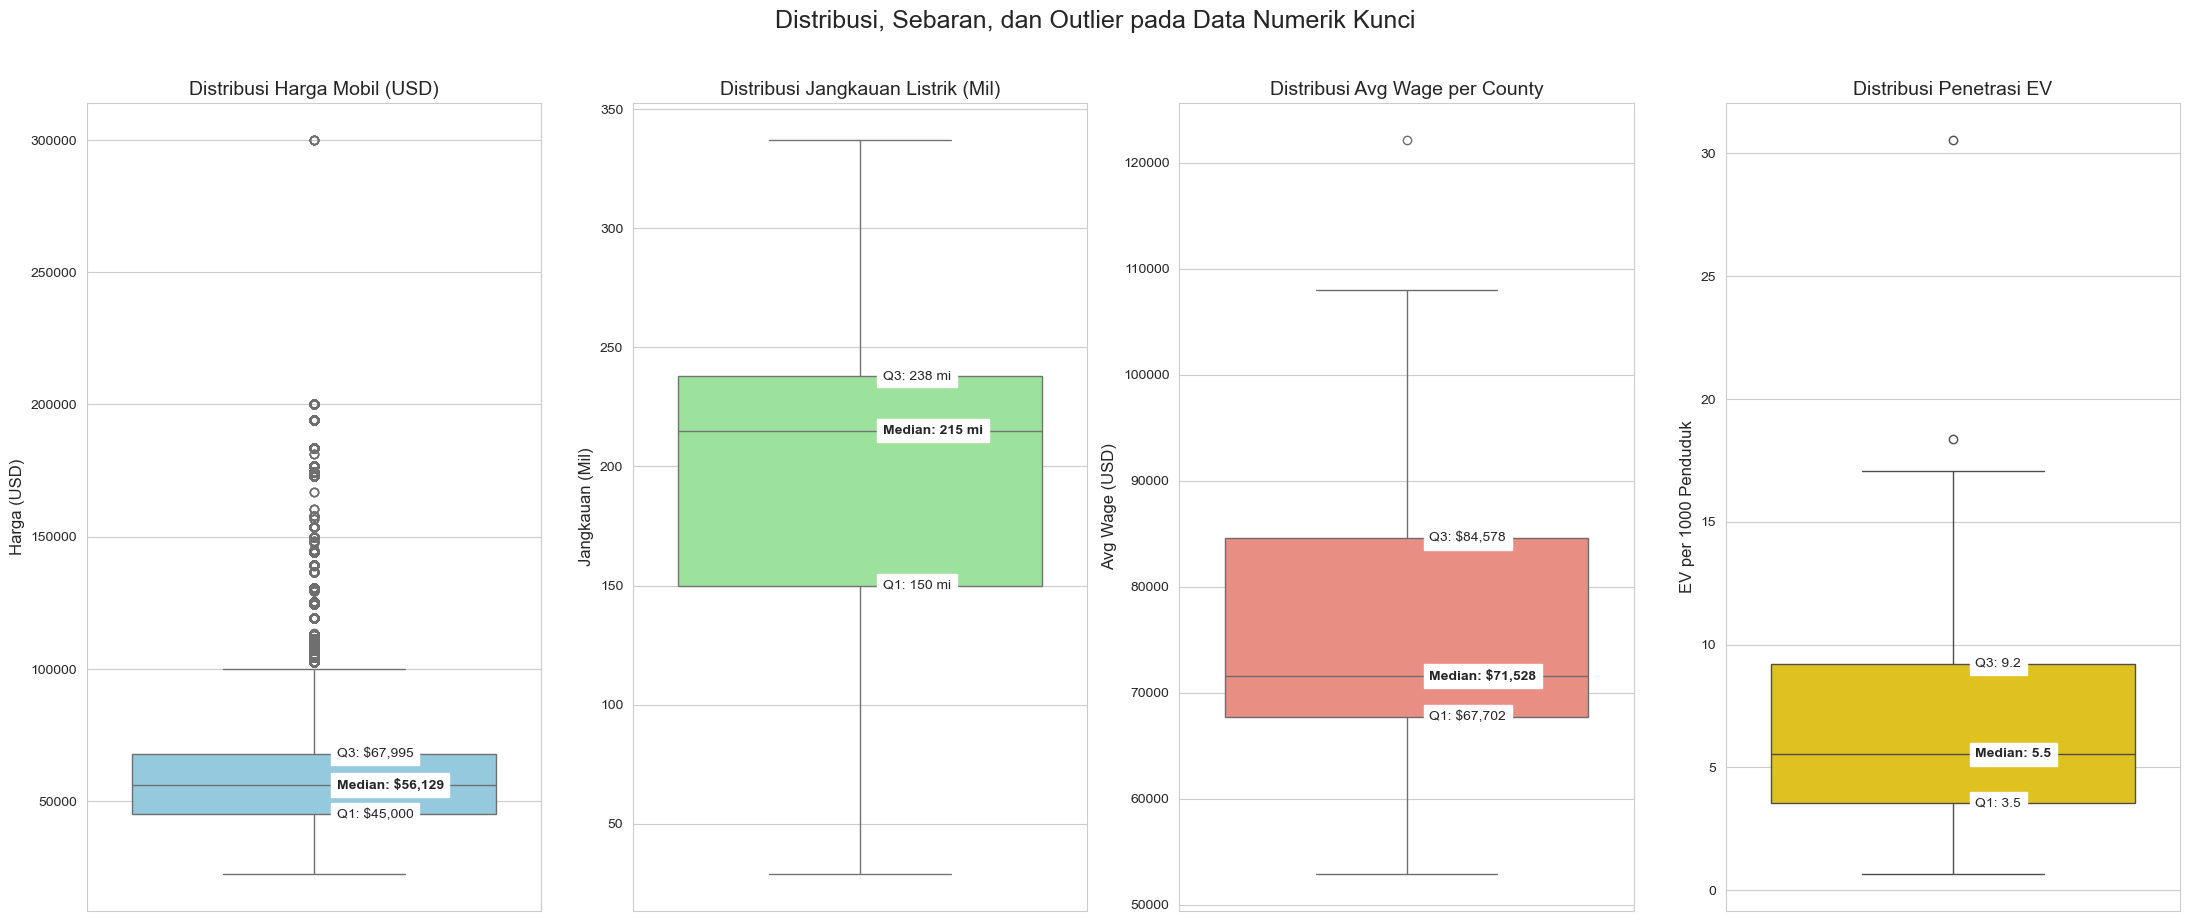

--- Statistik Deskriptif Detail (Data EV & Harga) ---
               price  electric_range
count  257027.000000   257027.000000
mean    63782.000572       43.115980
std     32370.234383       81.619388
min     22568.000000        0.000000
25%     45000.000000        0.000000
50%     56129.000000        0.000000
75%     67995.000000       35.000000
max    300000.000000      337.000000

--- Statistik Deskriptif Detail (Data Analisis per County) ---
            avg_wage    population  ev_penetration_rate
count      39.000000  3.900000e+01            39.000000
mean    76363.384615  5.533600e+05             7.460265
std     14832.480705  1.204072e+06             5.776858
min     52893.000000  5.995000e+03             0.667223
25%     67702.000000  5.452750e+04             3.532674
50%     71528.000000  1.740750e+05             5.537576
75%     84578.000000  4.856575e+05             9.227942
max    122148.000000  6.984875e+06            30.543356


In [22]:
plt.figure(figsize=(22, 9))
plt.suptitle('Distribusi, Sebaran, dan Outlier pada Data Numerik Kunci', fontsize=18, y=1.02)

# 1. Boxplot untuk Harga Mobil
ax1 = plt.subplot(1, 4, 1)
sns.boxplot(y=df_merged['price'], ax=ax1, color='skyblue')
ax1.set_title('Distribusi Harga Mobil (USD)', fontsize=14)
ax1.set_ylabel('Harga (USD)', fontsize=12)

price_stats = df_merged['price'].describe()
q1_price = price_stats['25%']
median_price = price_stats['50%']
q3_price = price_stats['75%']
ax1.text(0.05, q1_price, f'Q1: ${q1_price:,.0f}', va='center', ha='left', backgroundcolor='white')
ax1.text(0.05, median_price, f'Median: ${median_price:,.0f}', va='center', ha='left', backgroundcolor='white', fontweight='bold')
ax1.text(0.05, q3_price, f'Q3: ${q3_price:,.0f}', va='center', ha='left', backgroundcolor='white')


# 2. Boxplot untuk Jangkauan Listrik
ax2 = plt.subplot(1, 4, 2)
bev_range_data = df_merged[(df_merged['electric_vehicle_type'] == 'Battery Electric Vehicle (BEV)') & (df_merged['electric_range'] > 0)]
sns.boxplot(y=bev_range_data['electric_range'], ax=ax2, color='lightgreen')
ax2.set_title('Distribusi Jangkauan Listrik (Mil)', fontsize=14)
ax2.set_ylabel('Jangkauan (Mil)', fontsize=12)

range_stats = bev_range_data['electric_range'].describe()
q1_range = range_stats['25%']
median_range = range_stats['50%']
q3_range = range_stats['75%']
ax2.text(0.05, q1_range, f'Q1: {q1_range:.0f} mi', va='center', ha='left', backgroundcolor='white')
ax2.text(0.05, median_range, f'Median: {median_range:.0f} mi', va='center', ha='left', backgroundcolor='white', fontweight='bold')
ax2.text(0.05, q3_range, f'Q3: {q3_range:.0f} mi', va='center', ha='left', backgroundcolor='white')


# 3. Boxplot untuk Avg Wage (sebelumnya Gaji rata-rata)
ax3 = plt.subplot(1, 4, 3)
sns.boxplot(y=df_analysis['avg_wage'], ax=ax3, color='salmon')
ax3.set_title('Distribusi Avg Wage per County', fontsize=14)
ax3.set_ylabel('Avg Wage (USD)', fontsize=12)

avg_wage_stats = df_analysis['avg_wage'].describe()
q1_wage = avg_wage_stats['25%']
median_wage = avg_wage_stats['50%']
q3_wage = avg_wage_stats['75%']
ax3.text(0.05, q1_wage, f'Q1: ${q1_wage:,.0f}', va='center', ha='left', backgroundcolor='white')
ax3.text(0.05, median_wage, f'Median: ${median_wage:,.0f}', va='center', ha='left', backgroundcolor='white', fontweight='bold')
ax3.text(0.05, q3_wage, f'Q3: ${q3_wage:,.0f}', va='center', ha='left', backgroundcolor='white')


# 4. Boxplot untuk Tingkat Penetrasi EV
ax4 = plt.subplot(1, 4, 4)
sns.boxplot(y=df_analysis['ev_penetration_rate'], ax=ax4, color='gold')
ax4.set_title('Distribusi Penetrasi EV', fontsize=14)
ax4.set_ylabel('EV per 1000 Penduduk', fontsize=12)

pen_stats = df_analysis['ev_penetration_rate'].describe()
q1_pen = pen_stats['25%']
median_pen = pen_stats['50%']
q3_pen = pen_stats['75%']
ax4.text(0.05, q1_pen, f'Q1: {q1_pen:.1f}', va='center', ha='left', backgroundcolor='white')
ax4.text(0.05, median_pen, f'Median: {median_pen:.1f}', va='center', ha='left', backgroundcolor='white', fontweight='bold')
ax4.text(0.05, q3_pen, f'Q3: {q3_pen:.1f}', va='center', ha='left', backgroundcolor='white')


plt.tight_layout()
plt.show()

# Statistik deskriptif detail
print("--- Statistik Deskriptif Detail (Data EV & Harga) ---")
print(df_merged[['price', 'electric_range']].describe())
print("\n--- Statistik Deskriptif Detail (Data Analisis per County) ---")
print(df_analysis[['avg_wage', 'population', 'ev_penetration_rate']].describe())


##### **Interpretasi**
Analisis ini menyoroti gambaran harga dan performa EV, serta kondisi sosio-ekonomi per county. Hal ini penting untuk merancang strategi subsidi dan penetrasi EV yang lebih tepat sasaran.


##### **1. Data EV & Harga (`df_merged`)**

- **Harga Mobil (price):**
  - Rata-rata harga EV adalah **$63.782**, dengan median **$56.129**, menunjukkan distribusi harga relatif seimbang meskipun ada EV premium yang sangat mahal.
  - Sebanyak 50% EV berada di rentang **$45.000 – $67.995**, mencerminkan pasar menengah yang cukup dominan.
  - Harga minimum **$22.568** dan maksimum **$300.000** menegaskan segmentasi pasar: EV terjangkau vs EV premium.

- **Jangkauan Listrik (electric_range):**
  - Median jangkauan tercatat **0 mil**, kemungkinan besar akibat dominasi data PHEV atau entri yang tidak lengkap.
  - Nilai maksimum **337 mil** menunjukkan adanya model EV dengan performa baterai tinggi.
  - Analisis lebih akurat membutuhkan **pemisahan antara PHEV dan BEV**.


##### **2. Data Analisis per County (`df_analysis`)**

- **Upah Rata-Rata (avg_wage):**
  - Rata-rata upah per county adalah **$76.363**, dengan rentang tengah (Q1–Q3) **$67.702 – $84.578**.
  - County dengan upah tinggi (maksimum **$122.148**) berpotensi memiliki adopsi EV lebih tinggi.

- **Tingkat Penetrasi EV (ev_penetration_rate):**
  - Rata-rata **7.46 EV per 1000 penduduk**, median **5.54**, dengan variasi cukup besar (0.67 – 30.54).
  - Ini mengindikasikan adopsi EV sangat tidak merata: sebagian kecil county sangat tinggi, mayoritas masih rendah.



---
### **2. Faktor apa yang paling mempengaruhi penetrasi EV di tiap county?**


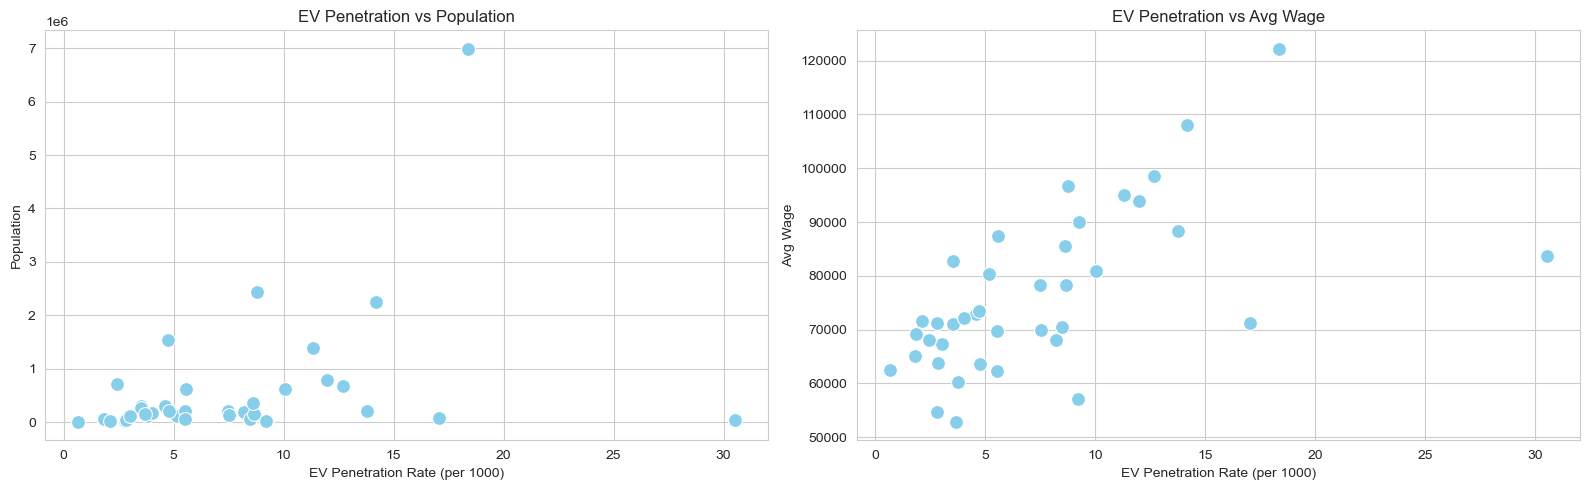

Korelasi EV Penetration Rate vs Faktor-faktor Lain:
       Factor  Correlation_with_EV_Penetration
0  population                             0.36
1    avg_wage                             0.59


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Faktor-faktor yang ingin dibandingkan dengan EV penetration rate
factors = ['population', 'avg_wage']

# Ukuran figure
plt.figure(figsize=(16, 5))

for i, factor in enumerate(factors, 1):
    plt.subplot(1, len(factors), i)
    sns.scatterplot(
        x='ev_penetration_rate',
        y=factor,
        data=df_analysis,
        color='skyblue',
        s=100
    )
    plt.xlabel('EV Penetration Rate (per 1000)')
    plt.ylabel(factor.replace('_', ' ').title())
    plt.title(f'EV Penetration vs {factor.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

# Hitung korelasi EV Penetration vs faktor-faktor lain
corr_factors = df_analysis[['ev_penetration_rate', 'population', 'avg_wage']].corr()['ev_penetration_rate'].drop('ev_penetration_rate').round(2)

# Konversi ke dataframe supaya lebih rapi
corr_table = corr_factors.reset_index()
corr_table.columns = ['Factor', 'Correlation_with_EV_Penetration']

print("Korelasi EV Penetration Rate vs Faktor-faktor Lain:")
print(corr_table)


**Interpretasi**

a. **Pendapatan rata-rata (`avg_wage`) → 0.59**  
   Faktor daya beli masyarakat lebih berpengaruh dibanding jumlah EV. County dengan pendapatan lebih tinggi cenderung memiliki penetrasi EV yang lebih besar karena konsumen mampu membeli EV. Dengan demikian, **semakin tinggi pendapatan, semakin besar potensi adopsi EV**. 
   
b. **Populasi (`population`) → 0.36**  
   Jumlah penduduk memiliki pengaruh paling kecil terhadap penetrasi EV. Ini menunjukkan bahwa **populasi besar saja tidak menjamin penetrasi tinggi**. 


**Temuan Penting dari Visualisasi**

a. **Outlier Benchmark pada Grafik EV Penetration vs Population**  
   Terlihat ada satu county dengan populasi besar namun juga memiliki **EV penetration rate relatif tinggi (sekitar 18 per 1000)**. Kasus ini bisa dijadikan benchmark bahwa **kombinasi populasi besar + penetrasi tinggi sangat mungkin terjadi**.

b. **Polarisasi Populasi Besar Lainnya**  
   Mayoritas county dengan populasi besar justru memiliki penetrasi EV rendah. Hal ini mengonfirmasi bahwa **jumlah penduduk tinggi tanpa daya beli dan supply EV yang kuat tidak akan otomatis meningkatkan penetrasi EV**.  

c. **Tren Konsisten pada EV Penetration vs Avg Wage**  
   Hubungan dengan avg_wage lebih jelas: county dengan gaji di atas **90.000–120.000** menunjukkan penetrasi EV yang relatif tinggi

---
### **3. Bagaimana tingkat penetrasi EV di tiap county jika dibandingkan dengan total populasi, dan sejauh mana tingkat rata rata gaji di wilayah tersebut memengaruhi keterjangkauan EV?**

Dikarenakan **wage (pendapatan rata-rata)** merupakan faktor yang paling berpengaruh terhadap tingkat penetrasi EV (korelasi 0.59), maka perlu dikaji lebih lanjut bagaimana daya beli masyarakat menentukan adopsi kendaraan listrik. 

/var/folders/23/qf75gzqs54g76t973jhch6yc0000gn/T/ipykernel_32379/1139763050.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/var/folders/23/qf75gzqs54g76t973jhch6yc0000gn/T/ipykernel_32379/1139763050.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='ev_penetration_rate', y='county', data=bottom_5_penetration,


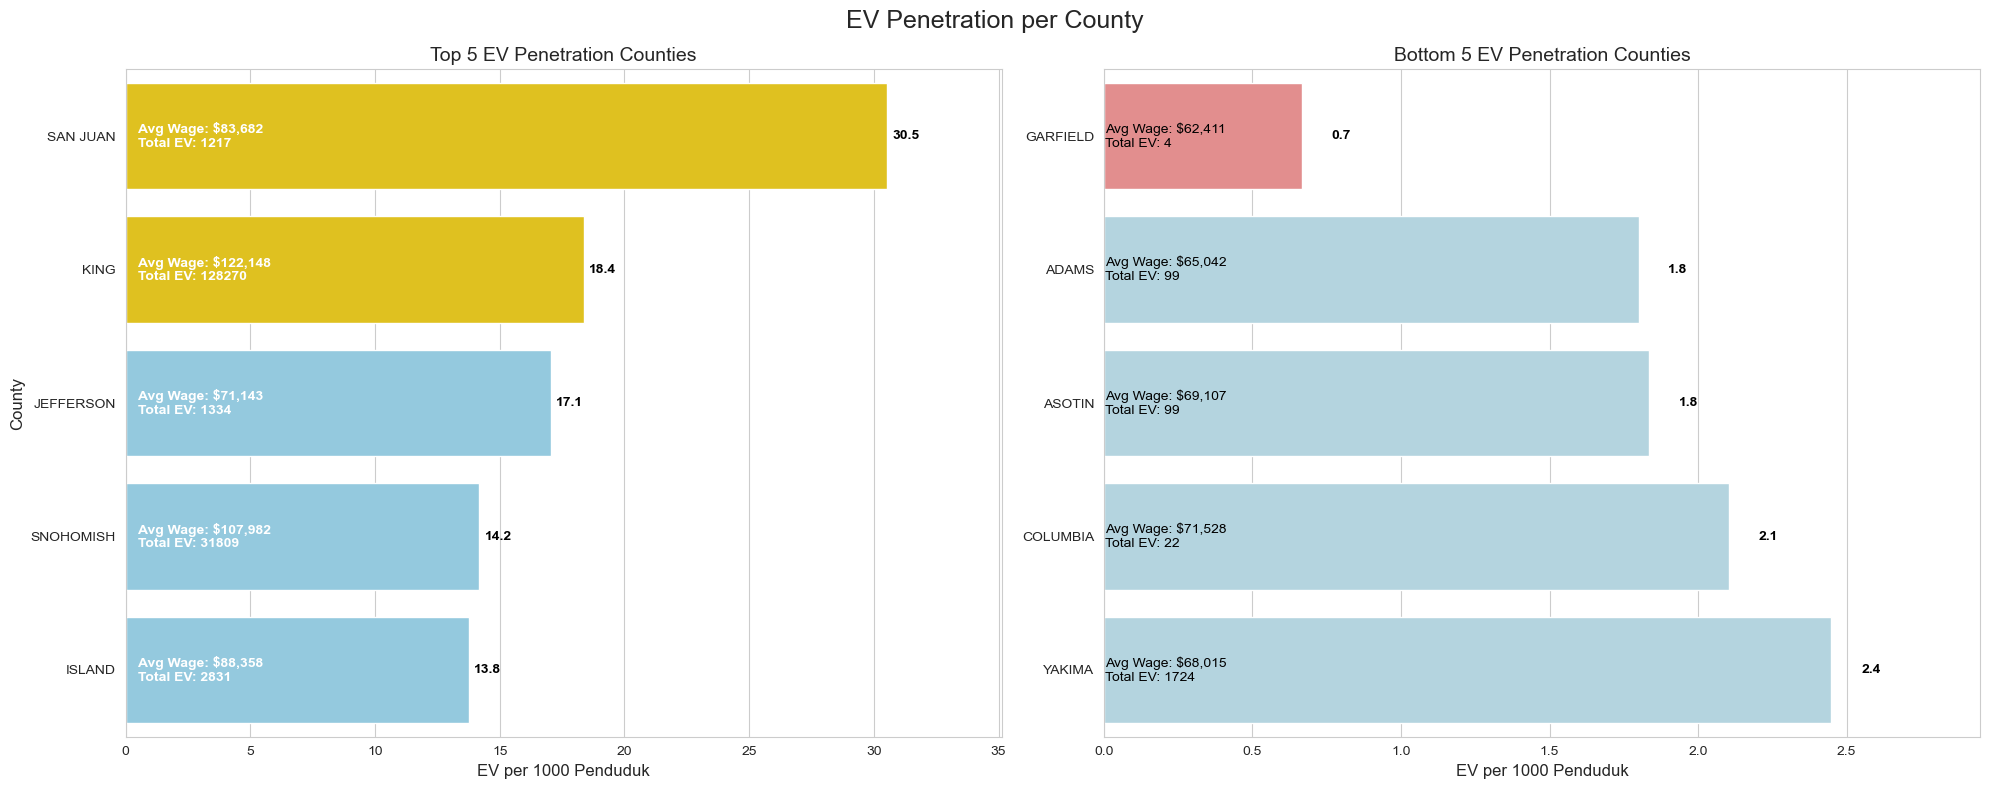

In [24]:
# Ambil top 5 dan bottom 5 penetration
top_5_penetration = df_analysis.nlargest(5, 'ev_penetration_rate')
bottom_5_penetration = df_analysis.nsmallest(5, 'ev_penetration_rate')

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1]})
fig.suptitle('EV Penetration per County', fontsize=18)

# --- Top 5 Penetrasi ---
colors_top = ['gold' if i < 2 else 'skyblue' for i in range(len(top_5_penetration))]

ax1 = sns.barplot(
    x='ev_penetration_rate', 
    y='county', 
    data=top_5_penetration,
    ax=axes[0], 
    palette=colors_top, 
    dodge=False
)

ax1.set_title('Top 5 EV Penetration Counties', fontsize=14)
ax1.set_xlabel('EV per 1000 Penduduk', fontsize=12)
ax1.set_ylabel('County', fontsize=12)

for i, (p_rate, avg_wage, ev_count) in enumerate(zip(
        top_5_penetration['ev_penetration_rate'], 
        top_5_penetration['avg_wage'], 
        top_5_penetration['ev_count']
    )):
    ax1.text(0.5, i, f'Avg Wage: ${avg_wage:,.0f}\nTotal EV: {ev_count}', 
             color='white', va='center', ha='left', fontweight='bold')
    ax1.text(p_rate + 0.2, i, f'{p_rate:.1f}', 
             color='black', va='center', fontweight='bold')

ax1.set_xlim(right=top_5_penetration['ev_penetration_rate'].max() * 1.15)



# --- Bottom 5 Penetrasi ---
colors_bottom = ['lightcoral' if i==0 else 'lightblue' for i in range(len(bottom_5_penetration))]
ax2 = sns.barplot(x='ev_penetration_rate', y='county', data=bottom_5_penetration,
                  ax=axes[1], palette=colors_bottom, dodge=False)
ax2.set_title('Bottom 5 EV Penetration Counties', fontsize=14)
ax2.set_xlabel('EV per 1000 Penduduk', fontsize=12)
ax2.set_ylabel('')

for i, (p_rate, avg_wage, ev_count) in enumerate(zip(bottom_5_penetration['ev_penetration_rate'], 
                                                      bottom_5_penetration['avg_wage'], 
                                                      bottom_5_penetration['ev_count'])):
    ax2.text(0.005, i, f'Avg Wage: ${avg_wage:,.0f}\nTotal EV: {ev_count}', color='black', va='center', ha='left')
    ax2.text(p_rate + 0.1, i, f'{p_rate:.1f}', color='black', va='center', fontweight='bold')
ax2.set_xlim(right=bottom_5_penetration['ev_penetration_rate'].max() + 0.5)

plt.tight_layout()
plt.show()


### **Interpretasi**:

#### **Top 5 EV Penetration Counties**

**a. San Juan**  
Memimpin dengan penetrasi EV tertinggi, yaitu **33 EV per 1000 penduduk** (total EV: **1.314 unit**). Gaji rata-rata sebesar **$83.682** (relatif tinggi)

**b. King County**  
Penetrasi EV **20,5 per 1000 penduduk** dengan **Gaji rata-rata tertinggi di antara top 5 ($122.148)**. Total EV mencapai **143.037 unit**

#### **Bottom 5 EV Penetration Counties**

**a. Garfield**  
Mencatat penetrasi EV terendah, yaitu hanya **0,5 per 1000 penduduk** (total EV: **3 unit**). Dengan Gaji rata-rata **$62.411**

**b. Asotin, Adams, Columbia, Ferry**  
Penetrasi EV hanya **1,8–2,5 per 1000 penduduk** dengan Gaji rata-rata rendah hingga sedang (**$54.650–$71.528**). Total EV pun sangat kecil (**23–103 unit**). 


---
### **4. Model EV apa yang paling banyak diminati, berapa harganya, dan sejauh mana harga tersebut sebanding dengan pendapatan tahunan masyarakat?**

Studi kasus menggunakan **King County** karena wilayah ini memiliki total EV terbesar di antara top 5 county sekaligus Gaji rata-rata tertinggi (merupakan kota metropolitan), menjadikannya representasi ideal untuk memahami perilaku pasar EV di area berpendapatan tinggi.

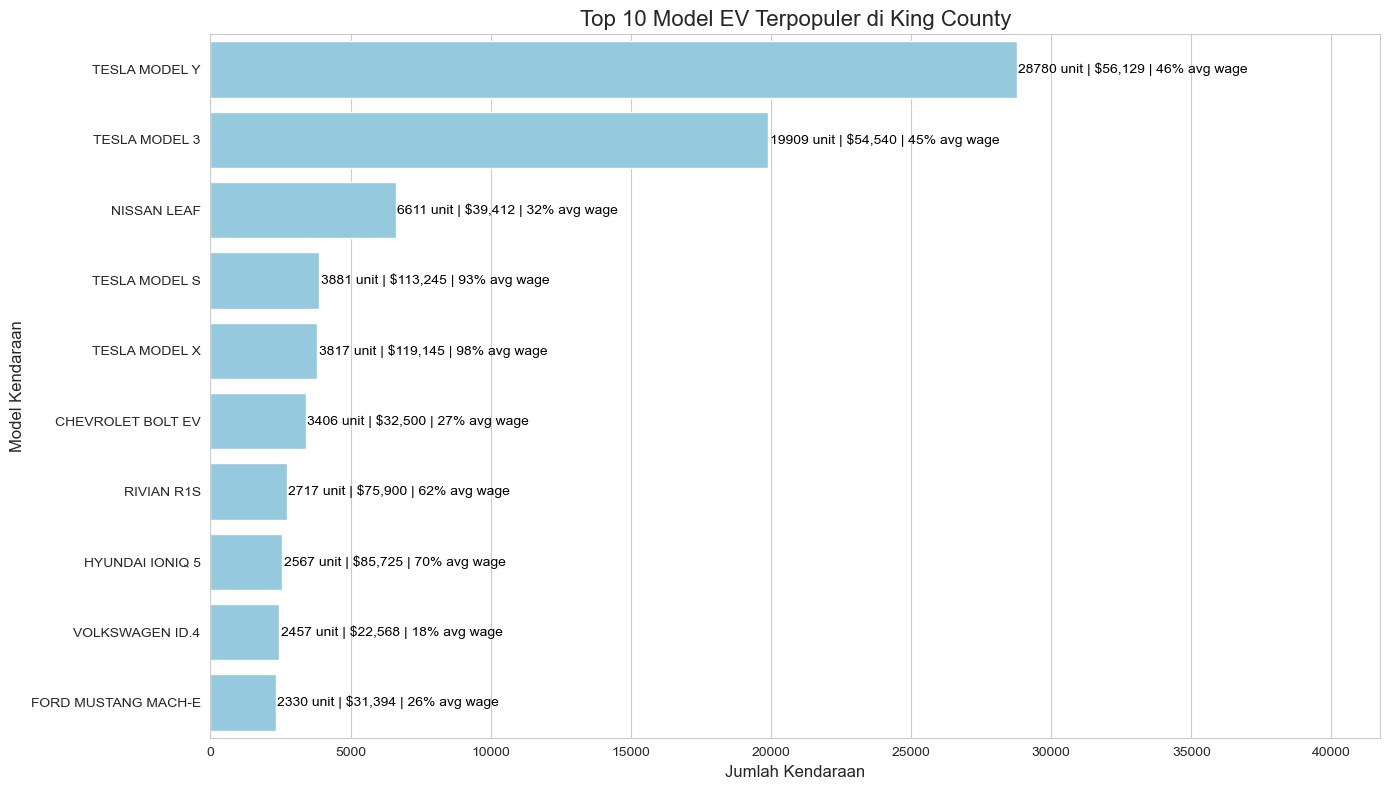

Rata-rata Harga EV (avg_price) King County: $122,148

Model EV terpopuler di King County dengan perbandingan harga vs avg_wage:
              make_model   price  count  avg_price_perc
153        TESLA MODEL Y   56129  28780       45.951632
150        TESLA MODEL 3   54540  19909       44.650752
130          NISSAN LEAF   39412   6611       32.265776
151        TESLA MODEL S  113245   3881       92.711301
152        TESLA MODEL X  119145   3817       97.541507
45     CHEVROLET BOLT EV   32500   3406       26.607067
140           RIVIAN R1S   75900   2717       62.137735
76       HYUNDAI IONIQ 5   85725   2567       70.181256
163      VOLKSWAGEN ID.4   22568   2457       18.475947
63   FORD MUSTANG MACH-E   31394   2330       25.701608


In [30]:
# 1. Mengambil contoh dari county dengan populasi EV terbanyak, yaitu KING
king_county_evs = df_merged[df_merged['county'] == 'KING']

# 2. Hitung model terpopuler (top 10) dengan harga
top_models_king = (
    king_county_evs
    .groupby(['make', 'model', 'price'])
    .size()
    .reset_index(name='count')
    .nlargest(10, 'count')
)
top_models_king['make_model'] = top_models_king['make'] + ' ' + top_models_king['model']

# 3. Hitung rata-rata harga EV King County (avg_wage) -- 
avg_price_king = king_county_evs['avg_wage'].mean() 

# 4. Tambahkan kolom perbandingan harga EV dengan avg_price 
top_models_king['avg_price_perc'] = (top_models_king['price'] / avg_price_king) * 100

# 5. Visualisasi dengan harga & count, semua warna sky blue
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='count',
    y='make_model',
    data=top_models_king,
    color='skyblue'  # semua bar berwarna sama
)
plt.title('Top 10 Model EV Terpopuler di King County', fontsize=16)
plt.xlabel('Jumlah Kendaraan', fontsize=12)
plt.ylabel('Model Kendaraan', fontsize=12)

# Tambahkan label jumlah unit + harga + persentase terhadap avg_price
for index, bar in enumerate(ax.patches):
    count = bar.get_width()  # jumlah unit
    price = top_models_king['price'].iloc[index]
    perc = top_models_king['avg_price_perc'].iloc[index]
    y_pos = bar.get_y() + bar.get_height() / 2

    ax.text(
        count + 50,
        y_pos,
        f"{int(count)} unit | ${price:,.0f} | {perc:.0f}% avg wage",
        color='black',
        va='center'
    )

# Sesuaikan batas sumbu X supaya label muat
ax.set_xlim(right=top_models_king['count'].max() * 1.45)

plt.tight_layout()
plt.show()

# 6. Tampilkan tabel ringkasan
print(f"Rata-rata Harga EV (avg_price) King County: ${avg_price_king:,.0f}\n")
print("Model EV terpopuler di King County dengan perbandingan harga vs avg_wage:")
print(top_models_king[['make_model', 'price', 'count', 'avg_price_perc']])


**Interpretasi:**
### **Mayoritas konsumen di King County**
1. Sebagai county dengan adopsi EV terbesar, King County dapat dijadikan gambaran pola belanja EV di Washington.
2. Sebagian besar konsumen(berdasarkan modus) bersedia mengalokasikan 40–50% daya belinya untuk EV populer seperti Tesla Model Y, Model 3, dan Nissan Leaf.
3. Angka ini menunjukkan EV sudah dianggap kebutuhan utama transportasi, bukan sekadar barang mewah.



### **5. Apakah terdapat perbedaan signifikan secara statistik dalam rata-rata tingkat penetrasi EV antara kelompok county dengan upah tinggi (kuartil atas) dan kelompok county dengan upah rendah (kuartil bawah)?**

**Penyusunan Hipotesis**:

`Hipotesis Nol (H0)`: Tidak ada perbedaan signifikan antara rata-rata tingkat penetrasi EV di county berupah tinggi dan county berupah rendah. Secara matematis: *μ_tinggi=μ_rendah*.

`Hipotesis Alternatif (H1)`: Terdapat perbedaan signifikan antara rata-rata tingkat penetrasi EV di county berupah tinggi dan county berupah rendah. Secara matematis: *μ_tinggi =μ_rendah*.

Batas Kuartil Bawah (Q1) untuk Upah: $67,702.00
Batas Kuartil Atas (Q3) untuk Upah: $84,578.00

--- Hasil Uji Hipotesis (Independent T-Test) ---
T-statistic: 5.6216
P-value: 0.000044

--- Keputusan & Kesimpulan ---
P-value (0.000044) < alpha (0.05). Keputusan: MENOLAK Hipotesis Nol (H0).
Kesimpulan: Terdapat perbedaan yang signifikan secara statistik dalam tingkat penetrasi EV antara county berupah tinggi dan rendah.


/var/folders/23/qf75gzqs54g76t973jhch6yc0000gn/T/ipykernel_32379/2383527800.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_to_plot, labels=labels, patch_artist=True, notch=True)


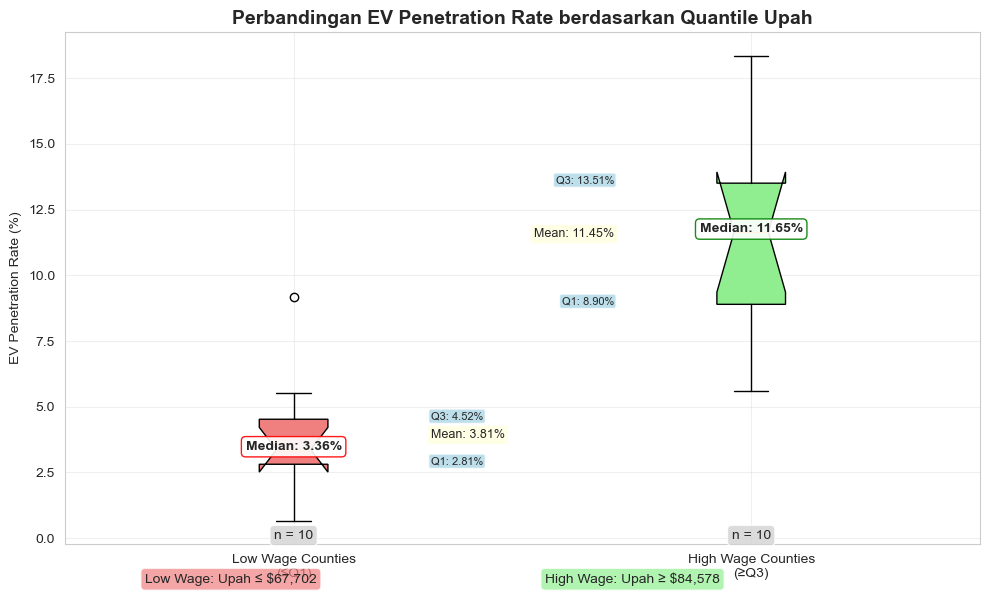

In [26]:
# Pastikan library sudah di-import di sel sebelumnya
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# ---- Mulai dari sini ----
# Asumsi df_analysis sudah ada dan siap digunakan

# 1. Menentukan batas kuartil untuk upah dari df_analysis
# Menggunakan nama kolom 'avg_wage'
q1_wage = df_analysis['avg_wage'].quantile(0.25)
q3_wage = df_analysis['avg_wage'].quantile(0.75)

print(f"Batas Kuartil Bawah (Q1) untuk Upah: ${q1_wage:,.2f}")
print(f"Batas Kuartil Atas (Q3) untuk Upah: ${q3_wage:,.2f}\n")

# 2. Memisahkan data menjadi dua kelompok berdasarkan kuartil
low_wage_counties = df_analysis[df_analysis['avg_wage'] <= q1_wage]
high_wage_counties = df_analysis[df_analysis['avg_wage'] >= q3_wage]

# Ekstrak nilai penetrasi rate untuk setiap kelompok
# Menggunakan nama kolom 'ev_penetration_rate'
penetration_low_wage = low_wage_counties['ev_penetration_rate']
penetration_high_wage = high_wage_counties['ev_penetration_rate']

# 3. Melakukan Independent T-Test
t_stat, p_value = ttest_ind(penetration_high_wage, penetration_low_wage, equal_var=False)

# 4. Menampilkan hasil dan menarik kesimpulan
print("--- Hasil Uji Hipotesis (Independent T-Test) ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}\n")

alpha = 0.05
print("--- Keputusan & Kesimpulan ---")
if p_value < alpha:
    print(f"P-value ({p_value:.6f}) < alpha ({alpha}). Keputusan: MENOLAK Hipotesis Nol (H0).")
    print("Kesimpulan: Terdapat perbedaan yang signifikan secara statistik dalam tingkat penetrasi EV antara county berupah tinggi dan rendah.")
else:
    print(f"P-value ({p_value:.6f}) >= alpha ({alpha}). Keputusan: GAGAL MENOLAK Hipotesis Nul (H0).")
    print("Kesimpulan: Tidak terdapat perbedaan yang signifikan secara statistik dalam tingkat penetrasi EV antara county berupah tinggi dan rendah.")

# 5. VISUALISASI - Box Plot Representasi Kedua Quantile
plt.figure(figsize=(10, 6))

# Box Plot Comparison: EV Penetration Rate by Wage Groups
data_to_plot = [penetration_low_wage, penetration_high_wage]
labels = ['Low Wage Counties\n(≤Q1)', 'High Wage Counties\n(≥Q3)']
box_plot = plt.boxplot(data_to_plot, labels=labels, patch_artist=True, notch=True)

# Mewarnai box plots
colors = ['lightcoral', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Perbandingan EV Penetration Rate berdasarkan Quantile Upah', fontweight='bold', fontsize=14)
plt.ylabel('EV Penetration Rate (%)')

# Menambahkan label nilai penting pada masing-masing quantile
low_median = penetration_low_wage.median()
high_median = penetration_high_wage.median()
low_mean = penetration_low_wage.mean()
high_mean = penetration_high_wage.mean()
low_q1 = penetration_low_wage.quantile(0.25)
low_q3 = penetration_low_wage.quantile(0.75)
high_q1 = penetration_high_wage.quantile(0.25)
high_q3 = penetration_high_wage.quantile(0.75)

# Label untuk Low Wage Group
plt.text(1, low_median, f'Median: {low_median:.2f}%', ha='center', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='red'))
plt.text(1.3, low_mean, f'Mean: {low_mean:.2f}%', ha='left', fontsize=9,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
plt.text(1.3, low_q1, f'Q1: {low_q1:.2f}%', ha='left', fontsize=8,
         bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.8))
plt.text(1.3, low_q3, f'Q3: {low_q3:.2f}%', ha='left', fontsize=8,
         bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.8))

# Label untuk High Wage Group  
plt.text(2, high_median, f'Median: {high_median:.2f}%', ha='center', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='green'))
plt.text(1.7, high_mean, f'Mean: {high_mean:.2f}%', ha='right', fontsize=9,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
plt.text(1.7, high_q1, f'Q1: {high_q1:.2f}%', ha='right', fontsize=8,
         bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.8))
plt.text(1.7, high_q3, f'Q3: {high_q3:.2f}%', ha='right', fontsize=8,
         bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.8))

# Menambahkan informasi jumlah data
plt.text(1, plt.ylim()[0] + 0.2, f'n = {len(penetration_low_wage)}', ha='center', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
plt.text(2, plt.ylim()[0] + 0.2, f'n = {len(penetration_high_wage)}', ha='center', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

# Menambahkan informasi batas quantile upah
plt.figtext(0.15, 0.02, f'Low Wage: Upah ≤ ${q1_wage:,.0f}', fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
plt.figtext(0.55, 0.02, f'High Wage: Upah ≥ ${q3_wage:,.0f}', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### **Interpretasi**:

1. Ccounty dengan upah rata-rata rendah (≤ $67,702) memiliki tingkat penetrasi EV
yang berbeda secara signifikan dibandingkan dengan county berupah tinggi (≥ $84,578). 
2. Hasil Independent T-Test menunjukkan T-statistic sebesar 5.62 dengan p-value 0.000044, 
yang jauh lebih kecil dari alpha 0.05, sehingga Hipotesis Nol (H0) ditolak.

**Kesimpulannya**, tingkat penetrasi EV cenderung lebih tinggi di county berupah tinggi dibandingkan county berupah rendah.
Perbedaan ini secara statistik signifikan, sehingga strategi subsidi atau insentif EV bisa mempertimbangkan 
kondisi upah rata-rata sebagai faktor diferensiasi wilayah.

---
## **VI. Pengambilan Kesimpulan & Rekomendasi Strategi Subsidi**

Analisis komprehensif menegaskan satu hipotesis utama: **adopsi kendaraan listrik (EV) sangat dipengaruhi faktor sosio-ekonomi wilayah**.  
- **Tingkat upah rata-rata** dan **kepadatan penduduk** adalah prediktor kuat tingkat penetrasi EV.  
- Hal ini menyoroti kelemahan strategi subsidi *“satu untuk semua”* → **butuh pendekatan tersegmentasi, presisi, dan berbasis data**.  

Berdasarkan korelasi *key questions*, rekomendasi strategi dapat dipetakan sebagai berikut:  

### **1. Segmentasi Strategi Subsidi**  
*(Korelasi: Key Question #1, #2, #5 → perbedaan pasar matang vs. pasar potensial)*

#### A. County Pertumbuhan Tinggi (Pasar Matang)  
Contoh: *King, Snohomish, Pierce – Top 5 Penetration Rate*  
- **Kondisi**: Adopsi sudah tinggi, daya beli kuat, infrastruktur dasar ada.  
- **Tantangan**: Mencapai saturasi & transisi penuh.  

**Fokus Subsidi**:
- Infrastruktur lanjutan (**dari unit → jaringan DC Fast Charging**).  
- Perluasan pilihan EV (SUV, truk listrik, premium).  
- Skema *trade-in* untuk upgrade EV generasi lama.  

#### B. County Potensi Tinggi (Pasar Awal)  
Contoh: *Ferry, Whitman, Garfield – Bottom 5 Penetration Rate*  
- **Kondisi**: Adopsi rendah, daya beli lemah, ekosistem belum ada.  
- **Tujuan**: Inisiasi adopsi EV.  

**Fokus Subsidi**:
- Subsidi harga langsung (point of sale).  
- Edukasi & awareness (workshop, local campaign, test-drive).  
- Infrastruktur dasar (stasiun Level 2 di kantor pemerintahan & pusat komunitas).  

---

### **2. Model EV & Skema Subsidi**  
*(Korelasi: Key Question #4 → keterjangkauan harga EV vs. daya beli)*  

- **Warga bersedia** mengalokasikan **40–45% dari gaji tahunan** untuk EV.  
- **Rata-rata gaji county terendah**: ± $60,000 → target harga EV: **$24,000–$27,000**.  
- **Model EV entry-level** (contoh: Chevrolet Bolt EV ≈ $32,500) masih terlalu mahal → butuh subsidi **$5,500–$8,500**.  

**Rekomendasi Konkret**:
- Subsidi langsung $5,500–$8,500 khusus untuk county berpenetrasi rendah.  
- Fokus pada model EV < $40,000:
  - Chevrolet Bolt EV  
  - Nissan LEAF (generasi baru)  
  - Model EV terjangkau lainnya 

---

### **3. Integrasi Kebijakan & Dampak**  
*(Korelasi lintas: Key Question #1–#5 → strategi menyeluruh)*  

- **Pasar Matang** → percepat transisi dengan infrastruktur & insentif trade-in.  
- **Pasar Potensial** → turunkan hambatan biaya awal & bangun ekosistem.  
- **Subsidi Diferensial** → menyesuaikan daya beli lokal, bukan subsidi rata.  

---

## **Kesimpulan Akhir**

Strategi subsidi efektif = **diferensiasi subsidi, bukan sama rata**.  

Dengan strategi **tersegmentasi & berbasis data**, pemerintah dapat:  
- Mempercepat adopsi EV **secara merata & adil**.  
- Memaksimalkan efektivitas **setiap subsidi harga**.  
- Mendukung tercapainya **target iklim & energi bersih nasional**.  
